<a href="https://colab.research.google.com/github/jear2412/MCMC/blob/master/SoilCarbonModelling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

import pandas as pd
import numpy as np
import pystan
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az
import scipy
sns.set()

import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
# si no tenes un paquete podes correr pip install paquete 


In [0]:

data=pd.read_csv('CO2-2.csv')
data=data.values


In [0]:
totalC_t0=7.7 #not included in data
t0=0
Nt=25
ts=data[0:25,1]
eco2mean=data[0:25,2]
eco2sd=data[0:25,3]


ts=ts.astype(float)
eco2mean=eco2mean.astype(float)
eco2sd=eco2sd.astype(float)



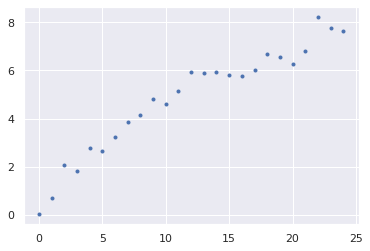

In [408]:
plt.plot(eco2mean,'.')

In [5]:

# Hamiltonian Monte Carlo through Stan

T=100000
bi=int(0.15*T)


stan_data ={"totalC_t0": totalC_t0,
            "t0": t0,
            "N_t": Nt,
            "ts": ts,
            "eCO2mean": eco2mean,
            }
model=pystan.StanModel( file='stan4model.stan' )

fit = model.sampling(data=stan_data, test_grad = False,
                 iter=T, warmup=bi, chains=2, n_jobs=2)




INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_4524ff07717ab81850baa788fefabcce NOW.


KeyboardInterrupt: ignored

In [6]:
print(fit)


NameError: ignored

In [0]:
model_dict=fit.extract()
model_dict.keys()


In [0]:
fit_df = fit.to_dataframe()
fit_df.keys()



In [0]:

def pplot_trace(param, param_name='parameter'):
    """Plot the trace and posterior of a parameter."""

    # Summary statistics
    mean = np.mean( param )
    median = np.median( param )
    cred_min, cred_max = np.percentile( param, 2.5 ), np.percentile( param, 97.5 )

    # Plotting
    plt.subplot( 2, 1, 1 )
    plt.plot( param )
    plt.xlabel( 'samples' )
    plt.ylabel( param_name )
    plt.axhline( mean, color='r', lw=2, linestyle='--' )
    plt.axhline( median, color='c', lw=2, linestyle='--' )
    plt.axhline( cred_min, linestyle=':', color='k', alpha=0.2 )
    plt.axhline( cred_max, linestyle=':', color='k', alpha=0.2 )
    plt.title( 'Trace and Posterior Distribution for {}'.format( param_name ) )

    plt.subplot( 2, 1, 2 )
    plt.hist( param, 30, density=True );
    sns.kdeplot( param, shade=True )
    plt.xlabel( param_name )
    plt.ylabel( 'density' )
    plt.axvline( mean, color='r', lw=2, linestyle='--', label='mean' )
    plt.axvline( median, color='c', lw=2, linestyle='--', label='median' )
    plt.axvline( cred_min, linestyle=':', color='k', alpha=0.2, label='95% CI' )
    plt.axvline( cred_max, linestyle=':', color='k', alpha=0.2 )

    plt.gcf().tight_layout()
    plt.legend()


In [0]:

az_data=az.from_pystan(fit)


In [0]:
az.plot_trace(az_data)
#each color represents a different chain


In [0]:
draw = fit_df['draw']
k1 = fit_df['k1']
k2 = fit_df['k2']
alpha21=fit_df['alpha21']
alpha12=fit_df['alpha12']
gamma=fit_df['gamma']
sigma=fit_df['sigma']

k1=pd.Series.to_numpy(k1)
k2=pd.Series.to_numpy(k2)
alpha12=pd.Series.to_numpy(alpha12)
alpha21=pd.Series.to_numpy(alpha21)
gamma=pd.Series.to_numpy(gamma)
sigma=pd.Series.to_numpy(sigma)





In [0]:
sns.distplot(k1, kde=False)



In [0]:
sns.distplot(k2, kde=False)


In [0]:
sns.distplot(alpha12, kde=False)


In [0]:
sns.distplot(alpha21,kde=False)


In [0]:
sns.distplot(gamma, kde=False)


In [0]:
sns.distplot(sigma, kde=False)

In [0]:
az.plot_pair(az_data, figsize=(16,9) , divergences=False, var_names=['k1', 'k2', 'alpha12', 'alpha21', 'gamma', 'sigma' ]);


In [0]:
q1=pd.DataFrame.quantile(fit_df, q=0.025)
q2=pd.DataFrame.quantile(fit_df, q=0.975)
medians=pd.DataFrame.median(fit_df)
q1=q1[9:34]
q2=q2[9:34]
medians=medians[9:34]

q1=pd.DataFrame.to_numpy(q1)
q2=pd.DataFrame.to_numpy(q2)
medians=pd.DataFrame.to_numpy(medians)

q1=np.append(0,q1)
q2=np.append(0,q2)
medians=np.append(0, medians)

In [0]:

plt.plot(times, medians  , label='Posterior median' )
plt.plot(times,np.append(0,eco2mean), '.',color='blue', label='Observed')
plt.fill_between( times, q1, q2 , alpha=0.6, color='red')
plt.xlabel( r'$t$' )
plt.ylabel( r'Evolved CO2' )
plt.title( 'Credibility bands eC02' )
plt.legend()
plt.savefig( 'eCO2-predictive.png', dpi=500  )
plt.show()


